In [1]:
import sys
#Install packages prefer conda if you are using anaconda otherwise try with pip, uncomment only if install is needed (if you use Google colab pip should work)
#It seeems that there are issues with GPyOpt on Python 3.9 in 2024, what worked for me was to force Python to version 3.6 (02463_environment_py36.yml)
#Otherwise the exercise still seems to run in google colab

#conda:
#os.system('conda install GPy -c conda-forge')
#os.system('conda install GPyOpt -c conda-forge')

#pip:
!{sys.executable} -m pip install GPy
!{sys.executable} -m pip install GPyOpt
!{sys.executable} -m pip install scikit-optimize
!{sys.executable} -m pip install scikit-posthocs


import numpy as np
import matplotlib.pyplot as plt
import GPyOpt
from torchvision import datasets, transforms, utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
import random
import seaborn as sns
import torch
import torch.nn as nn
import itertools
from torch.utils.data import DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import numpy as np

import skopt
from skopt import gp_minimize


sns.set_theme()
np.random.seed(32)
random.seed(32)


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Include dataset

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
torch.manual_seed(32)
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target


# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a custom PyTorch dataset
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the scaled ndarray
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Create dataset and dataloaders
train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check a batch
for features, labels in train_loader:
    print("Features:", features)
    print("Labels:", labels)
    break


Features: tensor([[-0.7426,  0.7565, -1.3333, -1.3126],
        [-0.8645, -1.2558, -0.4164, -0.1112],
        [-1.1082,  0.0857, -1.2760, -1.3126],
        [-0.0112, -1.0322,  0.1566,  0.0222],
        [ 0.3545, -0.5851,  0.1566,  0.1557],
        [-1.4739,  0.3093, -1.3333, -1.3126],
        [ 0.5983, -0.3615,  1.0735,  0.8232],
        [ 1.3297,  0.0857,  0.9589,  1.2236],
        [ 0.4764, -0.5851,  0.6151,  0.8232],
        [ 0.5983, -0.8086,  0.6724,  0.8232],
        [ 0.2326,  0.7565,  0.4432,  0.5562],
        [ 0.7202, -0.3615,  0.3286,  0.1557],
        [-0.7426,  0.9801, -1.2760, -1.3126],
        [-1.7177,  0.3093, -1.3906, -1.3126],
        [-0.1331,  2.9924, -1.2760, -1.0456],
        [-1.1082,  1.2037, -1.3333, -1.4461]])
Labels: tensor([0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0])


# Neural network arkitektur

In [3]:
import torch.nn as nn

class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(NeuralNetworkClassificationModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.input_layer(x))
        out = self.output_layer(out)
        return out

# Training module

In [4]:
# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()

def compute_test_loss(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)




> Random search  using SKOPT

In [6]:
from skopt import dummy_minimize
from skopt.space import Integer, Real
import torch.nn as nn
import random

criterion = torch.nn.CrossEntropyLoss()

# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()
lossRa = []
# Define the objective function for skopt
def objective_function(params):
    hidden_dim1, learning_rate = params
    model = NeuralNetworkClassificationModel(4, 3, hidden_dim1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and evaluate
    final_loss = train_network(model, optimizer, criterion, train_loader)
    test_loss = compute_test_loss(model, criterion, test_loader)

    print(f"Hidden dim: {hidden_dim1}, LR: {learning_rate}, Test Loss: {test_loss}")
    lossRa.append(test_loss)
    return test_loss  # Minimize test loss

# Define the search space
space = [
    Integer(4, 32, name='hidden_dim1'),  # Hidden layer size
    Real(0.000001, 0.1, name='learning_rate', prior='log-uniform')  # Learning rate
]

# Run skopt random search (equivalent to your original search)
resRandom = dummy_minimize(objective_function, space, n_calls=20, random_state=42)

# Extract best results
best_params = {
    'hidden_dim1': resRandom.x[0],
    'learning_rate': resRandom.x[1],
}
best_loss = resRandom.fun  # Best test loss found

print("Best parameters:", best_params)
print("Best loss:", best_loss)


Hidden dim: 23, LR: 0.056698495114788576, Test Loss: 0.05299428733997047
Hidden dim: 14, LR: 0.007915074397656225, Test Loss: 0.035140348598361015
Hidden dim: 24, LR: 6.026889128682514e-06, Test Loss: 0.9531109929084778
Hidden dim: 22, LR: 3.1613645505296136e-06, Test Loss: 0.9881350696086884
Hidden dim: 14, LR: 0.0214230217577411, Test Loss: 0.011961175128817558
Hidden dim: 7, LR: 5.180051644243016e-06, Test Loss: 1.1290400624275208
Hidden dim: 6, LR: 1.2674255898937238e-06, Test Loss: 1.178227186203003
Hidden dim: 5, LR: 0.004073745196058391, Test Loss: 0.04661317728459835
Hidden dim: 9, LR: 1.0090061869151558e-06, Test Loss: 1.0640725493431091
Hidden dim: 31, LR: 8.260808399079598e-06, Test Loss: 1.1029964089393616
Hidden dim: 15, LR: 0.0011435780278433413, Test Loss: 0.12730883806943893
Hidden dim: 32, LR: 0.00014445251022763073, Test Loss: 0.5361808240413666
Hidden dim: 20, LR: 0.0004206039057902, Test Loss: 0.24680805951356888
Hidden dim: 13, LR: 1.7113085338473876e-06, Test Loss

> Baysian optimization - Expected Improvement

In [7]:
best_loss = float('inf')
best_params = None
best_model = None
criterion = nn.CrossEntropyLoss()

iteration = 0

from skopt.space import Integer, Real, Categorical
# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()

lossEI = []
# Bayesian Optimization
def objective_function(params):
    hidden_dim1, learning_rate = params
    model = NeuralNetworkClassificationModel(4, 3, hidden_dim1)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    final_loss = train_network(model, optimizer, nn.CrossEntropyLoss(), train_loader)

    test_loss = compute_test_loss(model, nn.CrossEntropyLoss(), test_loader)

    # Print iteration count using enumerate
    print(f"Iteration {objective_function.counter}: Loss={final_loss}, Test loss={test_loss}, Params={params}")
    lossEI.append(test_loss)
    objective_function.counter += 1

    return test_loss  # Minimize loss

# Initialize iteration counter
objective_function.counter = 1

# Define search space
space = [
    Integer(4, 32, name='hidden_dim1'),
    Real(0.000001, 0.1, name='learning_rate', prior='log-uniform'),
]
initial_point = [4, 0.000001]

# Optimize
resEI = gp_minimize(objective_function, space, n_calls=20, random_state=42, acq_func="EI",x0=[initial_point])


best_params = {
    'hidden_dim1': resEI.x[0],
    'learning_rate': resEI.x[1],
}

print("Best parameters:", best_params)
print("Best loss:", resEI.fun)



Iteration 1: Loss=1.0219720602035522, Test loss=1.0910406708717346, Params=[4, 1e-06]
Iteration 2: Loss=1.1344178915023804, Test loss=1.1555335521697998, Params=[26, 8.263688714158015e-06]
Iteration 3: Loss=0.12068478763103485, Test loss=0.08460972271859646, Params=[26, 0.0009643857615941439]
Iteration 4: Loss=1.2172460556030273, Test loss=1.1789644956588745, Params=[16, 3.1613645505296136e-06]
Iteration 5: Loss=0.9552605152130127, Test loss=0.8710801303386688, Params=[17, 4.6616864139127715e-05]
Iteration 6: Loss=0.08289603888988495, Test loss=0.1000814251601696, Params=[8, 0.0017965626423790669]
Iteration 7: Loss=0.1277984231710434, Test loss=0.05011741537600756, Params=[6, 0.004073745196058391]
Iteration 8: Loss=0.9207459092140198, Test loss=0.8878017365932465, Params=[30, 1.0090061869151558e-06]
Iteration 9: Loss=0.1570589244365692, Test loss=0.056731848046183586, Params=[32, 0.0012229467525390618]
Iteration 10: Loss=1.276393175125122, Test loss=1.2302849292755127, Params=[21, 1.08

> Baysian optimization - Probability of Improvement

In [8]:
best_loss = float('inf')
best_params = None
best_model = None
criterion = nn.CrossEntropyLoss()

iteration = 0

from skopt.space import Integer, Real, Categorical
# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()

lossPI = []
# Bayesian Optimization
def objective_function(params):
    hidden_dim1, learning_rate = params
    model = NeuralNetworkClassificationModel(4, 3, hidden_dim1)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    final_loss = train_network(model, optimizer, nn.CrossEntropyLoss(), train_loader)

    test_loss = compute_test_loss(model, nn.CrossEntropyLoss(), test_loader)

    # Print iteration count using enumerate
    print(f"Iteration {objective_function.counter}: Loss={final_loss}, Test loss={test_loss}, Params={params}")
    lossPI.append(test_loss)
    objective_function.counter += 1

    return test_loss  # Minimize loss

# Initialize iteration counter
objective_function.counter = 1

# Define search space
space = [
    Integer(4, 32, name='hidden_dim1'),
    Real(0.000001, 0.1, name='learning_rate', prior='log-uniform'),
]
initial_point = [4, 0.000001]

# Optimize
resPI = gp_minimize(objective_function, space, n_calls=20, random_state=42, acq_func="PI",x0=[initial_point])


best_params = {
    'hidden_dim1': resPI.x[0],
    'learning_rate': resPI.x[1],
}

print("Best parameters:", best_params)
print("Best loss:", resPI.fun)



Iteration 1: Loss=1.1150411367416382, Test loss=1.1202811002731323, Params=[4, 1e-06]
Iteration 2: Loss=0.992766797542572, Test loss=1.0033907890319824, Params=[26, 8.263688714158015e-06]
Iteration 3: Loss=0.12663941085338593, Test loss=0.0907339621335268, Params=[26, 0.0009643857615941439]
Iteration 4: Loss=1.1123243570327759, Test loss=1.1169618368148804, Params=[16, 3.1613645505296136e-06]
Iteration 5: Loss=1.2123825550079346, Test loss=1.1044705510139465, Params=[17, 4.6616864139127715e-05]
Iteration 6: Loss=0.059466540813446045, Test loss=0.12139404565095901, Params=[8, 0.0017965626423790669]
Iteration 7: Loss=0.011987496167421341, Test loss=0.05281401239335537, Params=[6, 0.004073745196058391]
Iteration 8: Loss=1.1423237323760986, Test loss=1.1473846435546875, Params=[30, 1.0090061869151558e-06]
Iteration 9: Loss=0.05736285075545311, Test loss=0.05858932435512543, Params=[32, 0.0012229467525390618]
Iteration 10: Loss=0.9777505397796631, Test loss=0.9943850934505463, Params=[21, 1

> Baysian optimization - Lower Confidence Bound LCB

In [9]:
best_loss = float('inf')
best_params = None
best_model = None
criterion = nn.CrossEntropyLoss()

iteration = 0

from skopt.space import Integer, Real, Categorical
# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()

lossLCB = []
# Bayesian Optimization
def objective_function(params):
    hidden_dim1, learning_rate = params
    model = NeuralNetworkClassificationModel(4, 3, hidden_dim1)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    final_loss = train_network(model, optimizer, nn.CrossEntropyLoss(), train_loader)

    test_loss = compute_test_loss(model, nn.CrossEntropyLoss(), test_loader)

    # Print iteration count using enumerate
    print(f"Iteration {objective_function.counter}: Loss={final_loss}, Test loss={test_loss}, Params={params}")
    lossLCB.append(test_loss)
    objective_function.counter += 1

    return test_loss  # Minimize loss

# Initialize iteration counter
objective_function.counter = 1

# Define search space
space = [
    Integer(4, 32, name='hidden_dim1'),
    Real(0.000001, 0.1, name='learning_rate', prior='log-uniform'),
]

initial_point = [4, 0.000001]

# Optimize
resLCB = gp_minimize(objective_function, space, n_calls=20, random_state=42, acq_func="LCB",x0=[initial_point])


best_params = {
    'hidden_dim1': resLCB.x[0],
    'learning_rate': resLCB.x[1],
}

print("Best parameters:", best_params)
print("Best loss:", resLCB.fun)



Iteration 1: Loss=1.21547532081604, Test loss=1.099546194076538, Params=[4, 1e-06]
Iteration 2: Loss=1.1168935298919678, Test loss=1.0655704736709595, Params=[26, 8.263688714158015e-06]
Iteration 3: Loss=0.10508904606103897, Test loss=0.09813785925507545, Params=[26, 0.0009643857615941439]
Iteration 4: Loss=1.0405343770980835, Test loss=0.9994007050991058, Params=[16, 3.1613645505296136e-06]
Iteration 5: Loss=0.8987953066825867, Test loss=0.821195662021637, Params=[17, 4.6616864139127715e-05]
Iteration 6: Loss=0.1659615933895111, Test loss=0.091232193633914, Params=[8, 0.0017965626423790669]
Iteration 7: Loss=0.017079226672649384, Test loss=0.04919171705842018, Params=[6, 0.004073745196058391]
Iteration 8: Loss=1.1620407104492188, Test loss=1.120428442955017, Params=[30, 1.0090061869151558e-06]
Iteration 9: Loss=0.05637631192803383, Test loss=0.05887560732662678, Params=[32, 0.0012229467525390618]
Iteration 10: Loss=1.1268997192382812, Test loss=1.1788761615753174, Params=[21, 1.084754

> Analysis

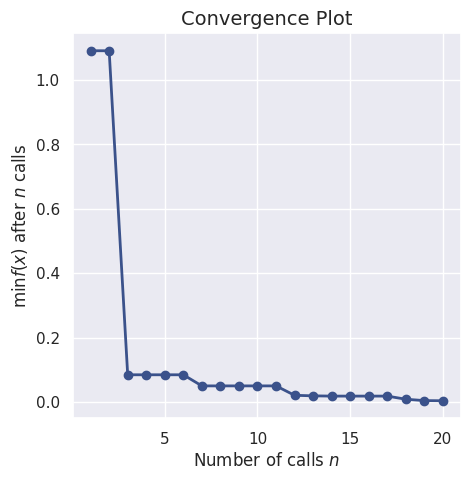

<Figure size 2000x2500 with 0 Axes>

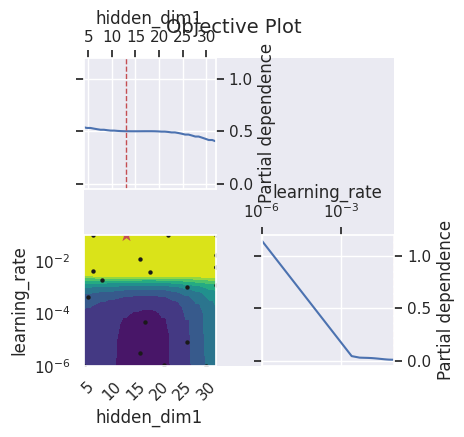

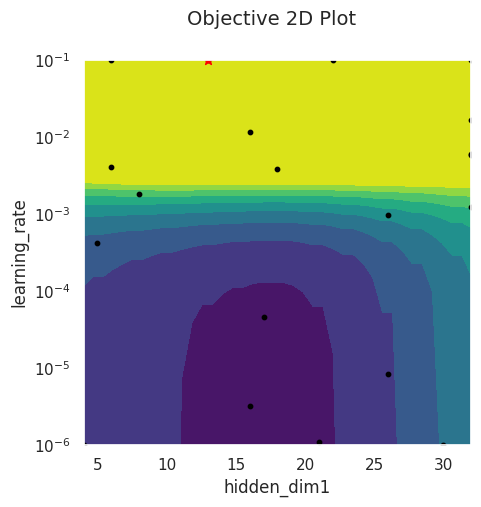

In [10]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective, plot_objective_2D
import matplotlib.pyplot as plt
model = resEI
# Increase figure size for better visualization
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12  # Increase font size

# Convergence Plot
plt.figure(figsize=(5, 5))
plot_convergence(model)
plt.title("Convergence Plot", fontsize=14)
plt.grid(True)
plt.show()

# Objective Plot
plt.figure(figsize=(20, 25))
plot_objective(model)
plt.suptitle("Objective Plot", fontsize=14)
plt.show()

# 2D Objective Plot
plt.figure(figsize=(5, 5))
plot_objective_2D(model, dimension_identifier1="hidden_dim1", dimension_identifier2="learning_rate")
plt.suptitle("Objective 2D Plot", fontsize=14)
plt.show()


# Test loss over iterations

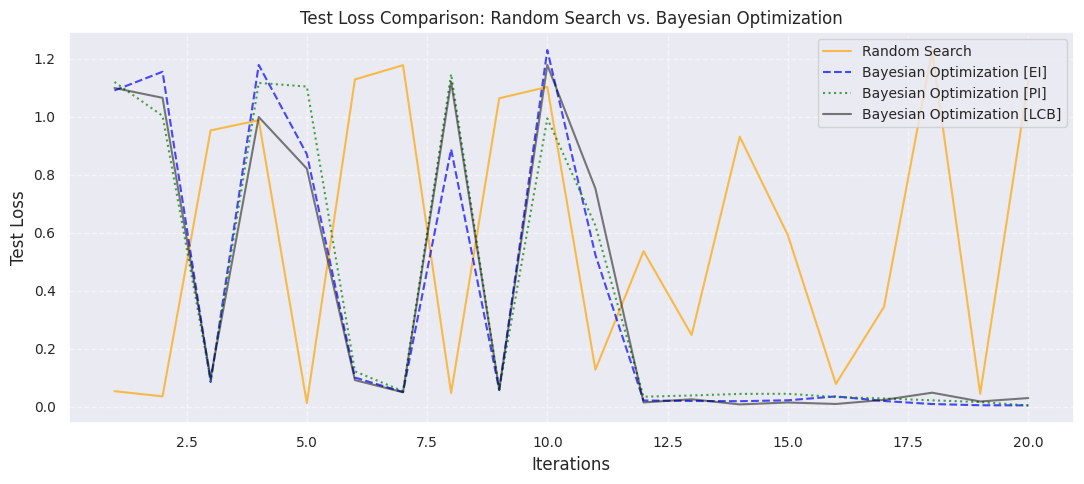

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define iteration numbers
iterations = np.arange(1, 21, 1)

# Plot test loss curves with different line styles and improved readability
plt.figure(figsize=(11, 5))

plt.plot(iterations, lossRa, '-', color='orange', label='Random Search', markersize=3, linewidth=1.5, alpha=0.7)
plt.plot(iterations, lossEI, '--', color='blue', label='Bayesian Optimization [EI]', markersize=3, linewidth=1.5, alpha=0.7)
plt.plot(iterations, lossPI, ':', color='green', label='Bayesian Optimization [PI]', markersize=3, linewidth=1.5, alpha=0.7)
plt.plot(iterations, lossLCB, '-', color='black', label='Bayesian Optimization [LCB]', markersize=3, linewidth=1.5, alpha=0.5)

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison: Random Search vs. Bayesian Optimization')

# Improve aesthetics
plt.legend(loc='upper right', fontsize=10)  # Move legend to avoid overlap
plt.grid(True, linestyle="--", alpha=0.5)  # Light grid for readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.tight_layout()
plt.savefig("test-loss.svg")
plt.show()


# Actual difference test (STATISTICAL TESTING)

**Expected improvement**

In [12]:
best_loss = float('inf')
best_params = None
best_model = None
criterion = nn.CrossEntropyLoss()

iteration = 0
trials = 20
score_EI = []

from skopt.space import Integer, Real, Categorical
# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()


# Bayesian Optimization
def objective_function(params):
    hidden_dim1, learning_rate = params
    model = NeuralNetworkClassificationModel(4, 3, hidden_dim1)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    final_loss = train_network(model, optimizer, nn.CrossEntropyLoss(), train_loader)

    test_loss = compute_test_loss(model, nn.CrossEntropyLoss(), test_loader)

    # Print iteration count using enumerate
    print(f"Iteration {objective_function.counter}: Loss={final_loss}, Test loss={test_loss}, Params={params}")

    objective_function.counter += 1

    return test_loss  # Minimize loss

# Initialize iteration counter
objective_function.counter = 1


for i_run in range(trials):


  # Define search space
  space = [
      Integer(4, 32, name='hidden_dim1'),
      Real(0.000001, 0.1, name='learning_rate', prior='log-uniform'),
  ]

  initial_point = [4, 0.1]

  # Optimize
  ressEI = gp_minimize(objective_function, space, n_calls=20, random_state=42, acq_func="EI",x0=[initial_point])


  best_params = {
      'hidden_dim1': ressEI.x[0],
      'learning_rate': ressEI.x[1],
  }

  print("Best parameters:", best_params)
  print("Best loss:", ressEI.fun)
  score_EI.append(ressEI.fun)

print(score_EI)


Iteration 1: Loss=0.07799575477838516, Test loss=0.03113460773602128, Params=[4, 0.1]
Iteration 2: Loss=0.8946875333786011, Test loss=0.9823055863380432, Params=[26, 8.263688714158015e-06]
Iteration 3: Loss=0.059176478534936905, Test loss=0.09388651326298714, Params=[26, 0.0009643857615941439]
Iteration 4: Loss=1.0069559812545776, Test loss=1.0161355137825012, Params=[16, 3.1613645505296136e-06]
Iteration 5: Loss=0.9352274537086487, Test loss=0.8537530601024628, Params=[17, 4.6616864139127715e-05]
Iteration 6: Loss=0.04459986463189125, Test loss=0.08897491358220577, Params=[8, 0.0017965626423790669]
Iteration 7: Loss=0.25307202339172363, Test loss=0.05256861634552479, Params=[6, 0.004073745196058391]
Iteration 8: Loss=0.9446377754211426, Test loss=0.9815509915351868, Params=[30, 1.0090061869151558e-06]
Iteration 9: Loss=0.037476032972335815, Test loss=0.07017027959227562, Params=[32, 0.0012229467525390618]
Iteration 10: Loss=1.154456615447998, Test loss=1.2132528424263, Params=[21, 1.0

**LCB**

In [17]:
best_loss = float('inf')
best_params = None
best_model = None
criterion = nn.CrossEntropyLoss()

iteration = 0
trials = 20
score_LCB = []

from skopt.space import Integer, Real, Categorical
# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()


# Bayesian Optimization
def objective_function(params):
    hidden_dim1, learning_rate = params
    model = NeuralNetworkClassificationModel(4, 3, hidden_dim1)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    final_loss = train_network(model, optimizer, nn.CrossEntropyLoss(), train_loader)

    test_loss = compute_test_loss(model, nn.CrossEntropyLoss(), test_loader)

    # Print iteration count using enumerate
    print(f"Iteration {objective_function.counter}: Loss={final_loss}, Test loss={test_loss}, Params={params}")

    objective_function.counter += 1

    return test_loss  # Minimize loss

# Initialize iteration counter
objective_function.counter = 1


for i_run in range(trials):


  # Define search space
  space = [
      Integer(4, 32, name='hidden_dim1'),
      Real(0.000001, 0.1, name='learning_rate', prior='log-uniform'),
  ]

  initial_point = [4, 0.1]

  # Optimize
  ressLCB = gp_minimize(objective_function, space, n_calls=20, random_state=42, acq_func="LCB",x0=[initial_point])


  best_params = {
      'hidden_dim1': ressLCB.x[0],
      'learning_rate': ressLCB.x[1],
  }

  print("Best parameters:", best_params)
  print("Best loss:", ressLCB.fun)
  score_LCB.append(ressLCB.fun)

print(score_LCB)


Iteration 1: Loss=0.15363942086696625, Test loss=0.019566571339964867, Params=[4, 0.1]
Iteration 2: Loss=1.119268774986267, Test loss=1.1315270066261292, Params=[26, 8.263688714158015e-06]
Iteration 3: Loss=0.1550886183977127, Test loss=0.09097715467214584, Params=[26, 0.0009643857615941439]
Iteration 4: Loss=1.211276650428772, Test loss=1.1710630059242249, Params=[16, 3.1613645505296136e-06]
Iteration 5: Loss=1.0947736501693726, Test loss=0.9697115123271942, Params=[17, 4.6616864139127715e-05]
Iteration 6: Loss=0.13307125866413116, Test loss=0.10252293199300766, Params=[8, 0.0017965626423790669]
Iteration 7: Loss=0.010396108962595463, Test loss=0.04657089617103338, Params=[6, 0.004073745196058391]
Iteration 8: Loss=1.0968406200408936, Test loss=1.0655349493026733, Params=[30, 1.0090061869151558e-06]
Iteration 9: Loss=0.03351927176117897, Test loss=0.05659879557788372, Params=[32, 0.0012229467525390618]
Iteration 10: Loss=0.9731335639953613, Test loss=0.8931011259555817, Params=[21, 1.

**Prob improvement**

In [16]:
best_loss = float('inf')
best_params = None
best_model = None
criterion = nn.CrossEntropyLoss()

iteration = 0
trials = 20
score_PI = []

from skopt.space import Integer, Real, Categorical
# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()


# Bayesian Optimization
def objective_function(params):
    hidden_dim1, learning_rate = params
    model = NeuralNetworkClassificationModel(4, 3, hidden_dim1)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    final_loss = train_network(model, optimizer, nn.CrossEntropyLoss(), train_loader)

    test_loss = compute_test_loss(model, nn.CrossEntropyLoss(), test_loader)

    # Print iteration count using enumerate
    print(f"Iteration {objective_function.counter}: Loss={final_loss}, Test loss={test_loss}, Params={params}")

    objective_function.counter += 1

    return test_loss  # Minimize loss

# Initialize iteration counter
objective_function.counter = 1


for i_run in range(trials):


  # Define search space
  space = [
      Integer(4, 32, name='hidden_dim1'),
      Real(0.000001, 0.1, name='learning_rate', prior='log-uniform'),
  ]

  initial_point = [4, 0.1]

  # Optimize
  ressPI = gp_minimize(objective_function, space, n_calls=20, random_state=42, acq_func="PI",x0=[initial_point])


  best_params = {
      'hidden_dim1': ressPI.x[0],
      'learning_rate': ressPI.x[1],
  }

  print("Best parameters:", best_params)
  print("Best loss:", ressPI.fun)
  score_PI.append(ressPI.fun)

print(score_PI)


Iteration 1: Loss=0.002235411200672388, Test loss=0.022609220817685127, Params=[4, 0.1]
Iteration 2: Loss=1.0882245302200317, Test loss=1.1427448987960815, Params=[26, 8.263688714158015e-06]
Iteration 3: Loss=0.1695171445608139, Test loss=0.08076425082981586, Params=[26, 0.0009643857615941439]
Iteration 4: Loss=0.9831265211105347, Test loss=1.0298571586608887, Params=[16, 3.1613645505296136e-06]
Iteration 5: Loss=0.7138410806655884, Test loss=0.9101724624633789, Params=[17, 4.6616864139127715e-05]
Iteration 6: Loss=0.0977557823061943, Test loss=0.1178150437772274, Params=[8, 0.0017965626423790669]
Iteration 7: Loss=0.10846654325723648, Test loss=0.04578567296266556, Params=[6, 0.004073745196058391]
Iteration 8: Loss=1.1919512748718262, Test loss=1.2124369144439697, Params=[30, 1.0090061869151558e-06]
Iteration 9: Loss=0.007533954456448555, Test loss=0.05145798530429602, Params=[32, 0.0012229467525390618]
Iteration 10: Loss=1.277369499206543, Test loss=1.2538329362869263, Params=[21, 1.

**Baseline (Random)**

In [18]:
from skopt import dummy_minimize
from skopt.space import Integer, Real
import torch.nn as nn
import random
trials = 20
score_RA = []
# Define the training function
def train_network(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return loss.item()
lossRa = []
# Define the objective function for skopt
def objective_function(params):
    hidden_dim1, learning_rate = params
    model = NeuralNetworkClassificationModel(4, 3, hidden_dim1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and evaluate
    final_loss = train_network(model, optimizer, criterion, train_loader)
    test_loss = compute_test_loss(model, criterion, test_loader)

    print(f"Hidden dim: {hidden_dim1}, LR: {learning_rate}, Test Loss: {test_loss}")
    lossRa.append(test_loss)
    return test_loss  # Minimize test loss
for i_run in range(trials):

  # Define the search space
  space = [
      Integer(4, 32, name='hidden_dim1'),  # Hidden layer size
      Real(0.000001, 0.1, name='learning_rate', prior='log-uniform')  # Learning rate
  ]

  # Run skopt random search (equivalent to your original search)
  resRandomR = dummy_minimize(objective_function, space, n_calls=20, random_state=42)

  # Extract best results
  best_params = {
      'hidden_dim1': resRandomR.x[0],
      'learning_rate': resRandomR.x[1],
  }
  best_loss = resRandomR.fun  # Best test loss found

  print("Best parameters:", best_params)
  print("Best loss:", best_loss)
  score_RA.append(best_loss)

print(score_RA)

Hidden dim: 23, LR: 0.056698495114788576, Test Loss: 0.018149480689316988
Hidden dim: 14, LR: 0.007915074397656225, Test Loss: 0.026350724510848522
Hidden dim: 24, LR: 6.026889128682514e-06, Test Loss: 1.2466233372688293
Hidden dim: 22, LR: 3.1613645505296136e-06, Test Loss: 0.9799110591411591
Hidden dim: 14, LR: 0.0214230217577411, Test Loss: 0.03168398980051279
Hidden dim: 7, LR: 5.180051644243016e-06, Test Loss: 1.0844301581382751
Hidden dim: 6, LR: 1.2674255898937238e-06, Test Loss: 1.2553700804710388
Hidden dim: 5, LR: 0.004073745196058391, Test Loss: 0.047407365404069424
Hidden dim: 9, LR: 1.0090061869151558e-06, Test Loss: 0.98735111951828
Hidden dim: 31, LR: 8.260808399079598e-06, Test Loss: 1.140344262123108
Hidden dim: 15, LR: 0.0011435780278433413, Test Loss: 0.0979628786444664
Hidden dim: 32, LR: 0.00014445251022763073, Test Loss: 0.5236533731222153
Hidden dim: 20, LR: 0.0004206039057902, Test Loss: 0.24975444376468658
Hidden dim: 13, LR: 1.7113085338473876e-06, Test Loss: 

> Statistical testing

In [49]:
np.mean(score_LCB)

0.00813378787424881

In [46]:
np.mean(score_RA)

0.01347013070480898

In [47]:
np.mean(score_EI)

0.007636342346086167

In [48]:
np.mean(score_PI)

0.008877831246354616

In [54]:
from scipy.stats import shapiro, kruskal, f_oneway, tukey_hsd
from scikit_posthocs import posthoc_dunn

loss_vals = [score_RA, score_EI, score_PI, score_LCB]

def compare_multiple_models(results, sig_level=0.05):
    # Check normality assumption
    shapiro_wilk = all(shapiro(i)[1] > sig_level for i in results)

    if shapiro_wilk == True:
        print("Data is normally distributed")
        # One-way ANOVA
        if f_oneway(*results)[1] > sig_level:
            print("No statistical difference")
        else:
            # Post-hoc pairwise comparisons test
            print("Statistically significant")

            tukey_hsd_results = tukey_hsd(*results)
            print(tukey_hsd_results)
    else:
        print("Data is not normally distributed")
        # Kruskal-Wallis test
        if kruskal(*results)[1] > sig_level:
            print("No statistical difference")
        else:
            # Post-hoc pairwise comparisons test
            print("Statistically significant")
            print("p-value", kruskal(*results)[1])
            dunn_results = posthoc_dunn(results, p_adjust="fdr_bh")
            print(dunn_results)

compare_multiple_models(loss_vals)

Data is not normally distributed
Statistically significant
p-value 0.002213707109825446
          1         2         3         4
1  1.000000  0.003868  0.028612  0.003868
2  0.003868  1.000000  0.530366  0.881008
3  0.028612  0.530366  1.000000  0.530366
4  0.003868  0.881008  0.530366  1.000000


In [56]:
import pandas as pd

In [60]:
print(pd.DataFrame(posthoc_dunn(loss_vals, p_adjust="fdr_bh")).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & 1 & 2 & 3 & 4 \\
\midrule
1 & 1.000000 & 0.003868 & 0.028612 & 0.003868 \\
2 & 0.003868 & 1.000000 & 0.530366 & 0.881008 \\
3 & 0.028612 & 0.530366 & 1.000000 & 0.530366 \\
4 & 0.003868 & 0.881008 & 0.530366 & 1.000000 \\
\bottomrule
\end{tabular}

